# Notes

This notebook is an example of a FETCHING and PRE-PROCESSING pipeline for sentinel-2 images. 
It is not meant to be run as a script, but rather to be used as a reference for how to the preprocessing functions.

*Example scenario*: We want to preprocess a sentinel-2 tile (~12k by 12k image) with data of the year 2022 to be used for data imputation and segmentation of fields.

*Author*: Jens d'Hondt (TU Eindhoven)

In [1]:
# General imports
import os
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Imports for STELAR-specific functions
import sys
sys.path.append("../")

# 1 Fetching the data

In [2]:
import os

# Set central data directory in which all data will be stored
DATADIR = "/home/jens/tue/0.STELAR/STELAR_VISTA/data/test"

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [3]:
from preprocessing import json_to_shape, fetch_s2_images

# Query images from the AWS Open Data Registry
startdate = dt.datetime(2022, 1, 1)
enddate = dt.datetime(2022, 12, 31)

# Use https://geojson.io to create a bbox and convert it to a geojson file.
aoi = json_to_shape("../aois/eindhoven.json")

max_cloud_cover = 10
limit = 2

items = fetch_s2_images(startdate, enddate, aoi, max_cloud_cover, limit)

print(f"Found {len(items)} tile images (one timestamp each)")

Found 2 tile images (one timestamp each)


In [4]:
items

id: S2A_31UFT_20221206_0_L2A
"bbox: [4.436135262583633, 51.324532702654174, 6.077742655077289, 52.341345926982605]"
datetime: 2022-12-06T10:56:37Z
platform: sentinel-2a
constellation: sentinel-2
instruments: ['msi']
gsd: 10
view:off_nadir: 0
proj:epsg: 32631
sentinel:utm_zone: 31
sentinel:latitude_band: U


# 2 Preprocessing

## 2.1 Combine images per tile

Here, we will group the images per tile (which is determined by the image's bounding box) and combine them into an EOPatch object. This object effectively packages the following info:
1. Pixel values for each band (RGB and NIR in this example).
2. Timestamps for each image.
3. Bounding box of the tile.
4. Data mask for each image
    - Currently configured to have a 1 value if pixel is classified as vegetation and 0 otherwise. 
    - Can be altered to have more classes.
    - Based on the Sentinel-2 L2A product's Scene Classification Layer (SCL) band (see https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/processing-levels/level-2 and https://docs.digitalearthafrica.org/en/latest/data_specs/Sentinel-2_Level-2A_specs.html).
    
SCL has the following original values;

| Value | Meaning |
| --- | --- |
| 0 | No data |
| 1 | Saturated or defective |
| 2 | Dark area pixels |
| 3 | Cloud shadows |
| 4 | Vegetation |
| 5 | Bare soils |
| 6 | Water |
| 7 | Unclassified |
| 8 | Cloud medium probability |
| 9 | Cloud high probability |
| 10 | Thin cirrus |
| 11 | Snow or ice |

In [6]:
"""
Group the queried images per tile, and preprocess each tile separately. This includes:
1 Downloading and combining the required bands
2 Transforming the SCL to a binary mask
3 Resampling the data to a common resolution
4 Combining and saving the images to a single EOPatch per tile
"""

from preprocessing import prepare_tile

aoi_name = "eindhoven"

# Group items by id as lists
grouped_items = {}
for item in items:
    id = item.id.split("_")[1]
    grouped_items[id] = grouped_items.get(id, []) + [item]

# Bands to be downloaded (should always include SCL)
bands = ["B02", "B03", "B04", "B08", "SCL"]

# Iterate each tile (in parallel) and process it
for tile_id, group_items in grouped_items.items():
    prepare_tile(tile_id=tile_id,
                 items=group_items, 
                 aoi_name=aoi_name, 
                 bands=bands, 
                 outdir=DATADIR)

Processing tile 31UFT
Processing item S2A_31UFT_20221206_0_L2A
Saving...
Processing tile 31UFS
Processing item S2A_31UFS_20221113_0_L2A
Saving...


In [3]:
# Check results

# Load an EOPatch
from eolearn.core import EOPatch

aoi_name = "eindhoven"

eopatch = EOPatch.load(f"{DATADIR}/eopatches/{aoi_name}_31UFT", lazy_loading=True)

eopatch

EOPatch(
  data: {
    BANDS: FeatureIO(/data/BANDS.npy)
  }
  mask: {
    IS_DATA: FeatureIO(/mask/IS_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((4.436135262583633, 51.324532702654174), (6.077742655077289, 52.341345926982605)), crs=CRS('4326'))
  timestamp: [datetime.datetime(2022, 12, 6, 10, 56, 37, tzinfo=tzutc())]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


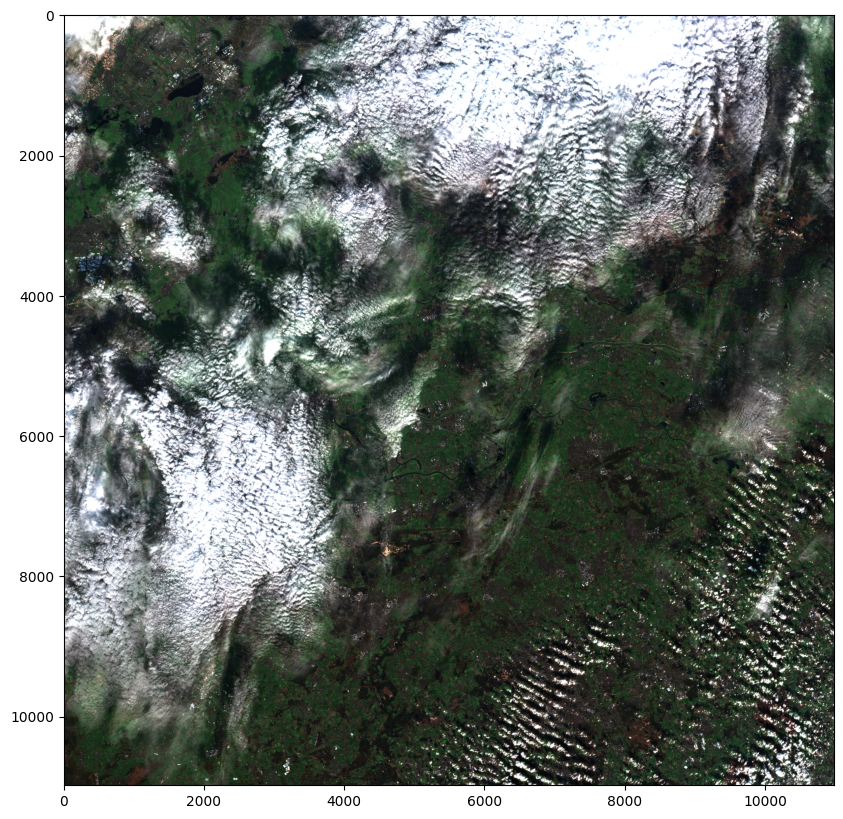

In [4]:
# Plot the RGB data
from eopatch_functions import plot_rgb

plot_rgb(eopatch, timestamp_idx=0)

## 2.2 LAI computation

Here, we will compute the Leaf Area Index (LAI) for each timestamp in the tile. 
Currently the LAI values are computed based on the following (simple) formula:
$$
EVI = 2.5 * \frac{NIR - RED}{NIR + 6 * RED - 7.5 * BLUE + 1}
$$
$$
LAI = 3.618 * EVI - 0.118 
$$

*Notes:*
- LAI values between 0 and 7 are seen as valid, other values are clipped to 0.
- LAI values are only computed for pixels that are classified as vegetation (see 2.1).
- The LAI values are stored in the EOPatch object as two separate arrays with the same shape as the image.

In [3]:
# Get eopatches of full tiles
aoi_name = "eindhoven"
eop_paths = glob.glob(f"{DATADIR}/eopatches/{aoi_name}_*")

eop_paths

['/home/jens/tue/0.STELAR/STELAR_VISTA/data/test/eopatches/eindhoven_31UFS']

In [4]:
from eopatch_functions import compute_lai
from pipeline.preprocessing.lib import multiprocess_map

# Compute LAI for all tiles (in parallel)

multiprocess_map(compute_lai, eop_paths, n_jobs=4)

  0%|          | 0/1 [00:00<?, ?it/s]/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/STELAR_VISTA/src/pipeline/preprocessing/eopatch_functions.py:121: RuntimeWarning: divide by zero encountered in divide
  EVI = 2.5 * ((NIR - R) / (NIR + 6 * R - 7.5 * B + 1))
/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/STELAR_VISTA/src/pipeline/preprocessing/eopatch_functions.py:121: RuntimeWarning: invalid value encountered in divide
  EVI = 2.5 * ((NIR - R) / (NIR + 6 * R - 7.5 * B + 1))
100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


[None]

## 2.3 Splitting to patchlets (optional)

Next, we will split the EOPatches containing the data for full tiles (12k by 12k pixels) into smaller patchlets (1128 by 1128 pixels) with slight overlap between them. This is done to make the data more manageable for the next steps in the pipeline, particularly segmentation, for which the model works best with smaller images.

In [6]:
# Get eopatches of full tiles
aoi_name = "eindhoven"
eop_paths = glob.glob(f"{DATADIR}/eopatches/{aoi_name}_*")

eop_paths

['/home/jens/tue/0.STELAR/STELAR_VISTA/data/test/eopatches/eindhoven_31UFT',
 '/home/jens/tue/0.STELAR/STELAR_VISTA/data/test/eopatches/eindhoven_31UFS']

In [5]:
from pipeline.preprocessing.lib import multiprocess_map
from preprocessing import split_tile_into_patchlets

# For each tile, split it into smaller patchlets (in parallel)
patchlet_size = (1128,1128)
buffer = 100

multiprocess_map(func=split_tile_into_patchlets, object_list=eop_paths, n_jobs=2, 
                 patchlet_size=patchlet_size, buffer=buffer, output_dir=DATADIR)

  0%|          | 0/2 [00:00<?, ?it/s]/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/STELAR_VISTA/.venv/lib/python3.10/site-packages/eolearn/core/eodata.py:784: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not issubclass(value.dtype.type, (np.integer, bool, np.bool_, np.bool8)):
/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/STELAR_VISTA/.venv/lib/python3.10/site-packages/eolearn/core/eodata.py:784: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not issubclass(value.dtype.type, (np.integer, bool, np.bool_, np.bool8)):
100%|██████████| 2/2 [00:25<00:00, 12.98s/it]


[None, None]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


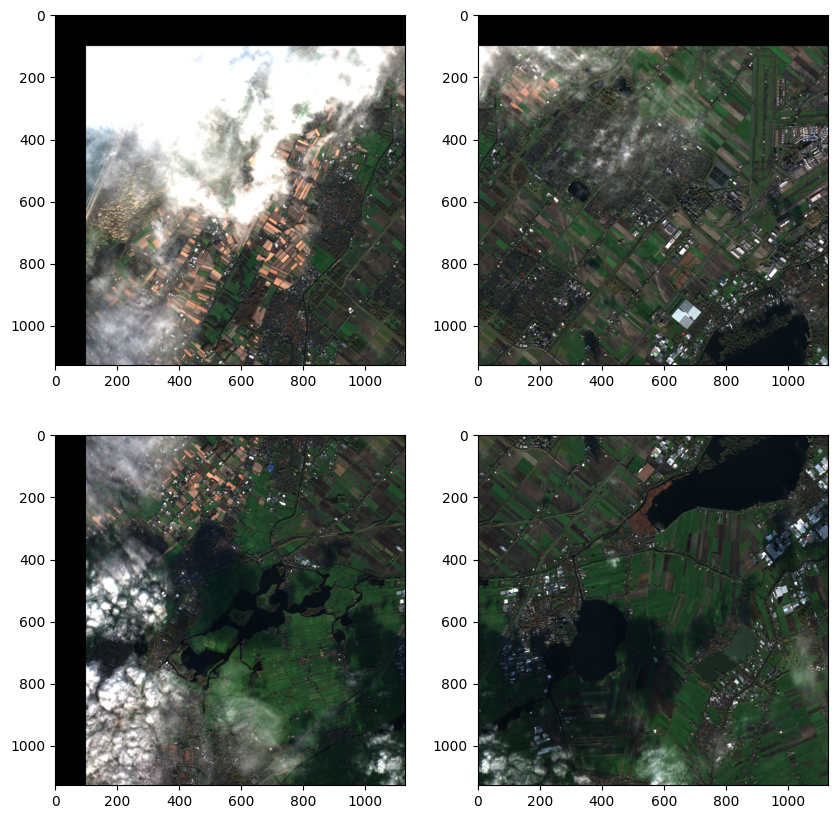

In [8]:
# Check patchlets results (with overlap)
eop_name = os.path.basename(eop_paths[0])

indir = os.path.join(DATADIR, "patchlets", eop_name)
eop1 = EOPatch.load(indir + "/patchlet_0_0", lazy_loading=True)
eop2 = EOPatch.load(indir + "/patchlet_1_0", lazy_loading=True)
eop3 = EOPatch.load(indir + "/patchlet_0_1", lazy_loading=True)
eop4 = EOPatch.load(indir + "/patchlet_1_1", lazy_loading=True)

fig,axes = plt.subplots(2,2,figsize=(10,10))

plot_rgb(eop1, 0, axes[0,0])
plot_rgb(eop2, 0, axes[0,1])
plot_rgb(eop3, 0, axes[1,0])
plot_rgb(eop4, 0, axes[1,1])